<a href="https://colab.research.google.com/github/NavePnow/Fake-News-Final/blob/master/GloVe%2BXgBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embedding

## 1. Preprocessing

In [0]:
!pip install glove_python

     |████████████████████████████████| 266kB 6.3MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700307 sha256=6697a39f7687c340c44d93f1e63a00f76418adf9d2e11b0b57ea5d4fdc952401
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import spacy
import string
import re
import nltk
from spacy.symbols import ORTH
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
import nltk
nltk.download('gutenberg')
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')

import os
ROOTDIR = os.path.abspath(os.path.dirname('__file__'))
DATADIR = os.path.join(ROOTDIR, 'data')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
import pandas as pd

dat = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fake_or_real_news.csv')
dat.head()

,Unnamed: 0,title,text,label,title_vectors
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,[ 1.1533764e-02 4.2144405e-03 1.9692603e-02 ...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,[ 0.11267698 0.02518966 -0.00212591 0.021095...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,[ 0.04253004 0.04300297 0.01848392 0.048672...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,[ 0.10801624 0.11583211 0.02874823 0.061732...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,[ 1.69016439e-02 7.13498285e-03 -7.81233795e-...


In [0]:
dat = dat.drop(columns=['Unnamed: 0', 'title_vectors'])
for i in range(len(dat)):
    if dat.loc[i, 'label'] == "REAL": #REAL equal 0
        dat.loc[i, 'label'] = 0
    elif dat.loc[i, 'label'] == "FAKE": #FAKE equal 1
        dat.loc[i, 'label'] = 1
    if dat.loc[i, 'text'] == "":
        dat = dat.drop([i])
dat.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [0]:
dat_plus = dat.copy()
dat_plus['title_text']=dat['title']+'. '+dat['text']
dat_plus = dat_plus.drop(columns=['title', 'text'])
#dat_plus['col']=dat_plus['col1']+dat_plus['col2']
texts = dat_plus.title_text.values #pd.Series -> np.ndarray
label = dat_plus.label.values #pd.Series -> np.ndarray

In [0]:
dat_plus

,label,title_text
0,1,You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matte...
5,1,"Tehran, USA. \r\nI’m not an immigrant, but m..."
6,1,Girl Horrified At What She Watches Boyfriend D...
7,0,‘Britain’s Schindler’ Dies at 106. A Czech sto...
8,0,Fact check: Trump and Clinton at the 'commande...
9,0,Iran reportedly makes new push for uranium con...


## 2. Use the libary spacy to tokenize data

In [0]:
# borrowed from fast.ai (https://github.com/fastai/fastai/blob/master/fastai/nlp.py)
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x)

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

In [0]:
nlp = spacy.load('en')
#tokenized = [nlp(sentences) for sentences in texts] #split word = transfer sentences into words
#doc = nlp(texts[0])

In [0]:
#tokenized[]

## 3. Get Non-Stopwords

In [0]:
# get stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stops=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def get_non_stopwords(review):
    """Returns a list of non-stopwords"""
    return {x:1 for x in spacy_tok(str(review).lower()) if x not in stops}.keys()

## 4. Read the 300 dimensional Glove embeddings into a dictionary.

In [0]:
# After downloading: /content/drive/My Drive/Colab Notebooks/fake_or_real_news.csv
globe_path = "/content/drive/My Drive/glove.6B.300d.txt"

In [0]:
def load_word_embeddings(file=globe_path):
    embeddings={}
    with open(file,'r') as infile:
        for line in infile:
            values=line.split()
            embeddings[values[0]]=np.asarray(values[1:],dtype='float32')
    return embeddings

In [0]:
embeddings = load_word_embeddings()

In [0]:
len(embeddings.keys())

400000

## 5. Create average feature embedding for each sentence (stopwords ignored)

In [0]:
def sentence_features_v2(s, embeddings=embeddings,emb_size=300):
    # ignore stop words
    words=get_non_stopwords(s)
    words=[w for w in words if w.isalpha() and w in embeddings]
    if len(words)==0:
        return np.hstack([np.zeros(emb_size)])
    M=np.array([embeddings[w] for w in words])
    return M.mean(axis=0)

## 6. Split the dataset

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test sets
seed = 42
test_size = 0.33
trn, test, y_train, y_test = train_test_split(texts, label, test_size=test_size, random_state=seed)
print(trn.shape)

(4244,)


In [0]:
y_train = np.array(y_train, dtype=int)
y_test =  np.array(y_test, dtype=int)


In [0]:
# create sentence vectors
x_train = np.array([sentence_features_v2(x) for x in trn])
x_test = np.array([sentence_features_v2(x) for x in test])

In [0]:
x_train.shape, x_test.shape

((4244, 300), (2091, 300))

In [0]:
y_train.shape, y_test.shape

((4244,), (2091,))

# **Classification and Hypertuning**

## 1. KNN Classifier

There are three key hyperparameters that needs to be hypertuned, namely :


1.   n_neighbor
2.   weight
3.   p



In [0]:
# Group1 Yichen Liu 2019.8

# First try a randomly set KNN Classifier

from sklearn.neighbors import KNeighborsClassifier
# First try out default parameters 
knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_clf.fit(x_train, y_train)
knn_clf.score(x_test, y_test)

0.7986609277857485

Start Hypertuning

In [0]:
# Group1 Yichen Liu 2019.8


# Find best hyperparameter 'k' & 'weight'
best_method = ""
best_score = 0.0
best_k = -1
for method in ["uniform", "distance"]:
    for k in range(1, 11):
        knn_clf = KNeighborsClassifier(n_neighbors = k)
        knn_clf.fit(x_train, y_train)
        knn_score = knn_clf.score(x_test, y_test)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_method = method

print("best_method = ", best_method)
print("best_k = ", best_k)
print("best_score = ", best_score)

best_method =  uniform
best_k =  3
best_score =  0.8110951697752271


As 'p' is only useful when 'weight' = distance, there is no need to further explore 'p'.

In [0]:
y_pred = knn_clf.predict(x_test)

Visualize the process

In [0]:
# Use AUC as the evaluation metirc
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7747432306255835

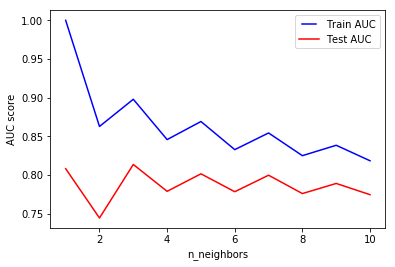

In [0]:
# Group1 Yichen Liu 2019.8

# Visualizing the hyperytuning results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

neighbors = list(range(1,11))
train_results = []
test_results = []
for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors,train_results,'b', label='Train AUC')
line2, = plt.plot(neighbors,test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')

plt.show()

In [0]:
from sklearn.metrics import classification_report
y_pred = knn_clf.predict(x_test)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [0]:
# Group1 Yichen Liu 2019.8

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

confusion matrix: 
[[970  50]
 [430 641]]
precision:   0.928
recall:   0.599
f1:   0.728


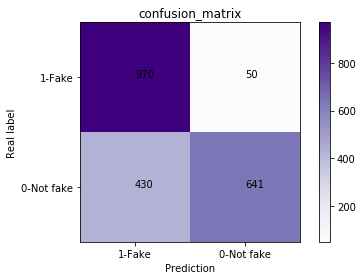

In [0]:
# Group1 Yichen Liu 2019.8

# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

We can see from above that our current model has reached :


1.   precision = 0.928
2.   recall = 0.599
3.   f1-score= 0.728

which is rather unsatisfactory.

## 2. Xgboost Classifier

There are basically 10 hyperparameters that needs to be hypertuned.

1.    'max_depth'
2.   'learning_rate'
3.   'n_estimators'
4.   'min_child_weight'
5.   'max_delta_step'
6.    'subsample'
7.    'colsample_bytree'
8. 'reg_alpha'
9.              'reg_lambda'
10.              'scale_pos_weight'


Hypertuning method: 

We first tried to use grid search to hypertune all the parameters at the same time, but found it rather time-comsuming (with excution time more than 12 hours), so we decide to split the hypertunng process into seperate ones so that it may be easier and more operable. The loss of accuracy is almost negligible.

First we use grid search to determine the most suitable value for three different hyperparameters respectively, then fix them and hypertune other parameters.

In [0]:
import xgboost as xgb
import pandas as pd

Start Hypertuning

In [0]:
# Group1 Yichen Liu 2019.8
# Excecution Time = 1313.333s

# Find best 'max_depth'

from sklearn.model_selection import GridSearchCV
parameters = {
              'max_depth': [5, 10, 15, 20,25]
}
    
xlf = xgb.XGBClassifier(max_depth=10,
			learning_rate=0.01,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=1,
			max_delta_step=0,
			subsample=0.85,
			colsample_bytree=0.7,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Best score: 0.867
Best parameters set:
	max_depth: 5


In [0]:
# Group1 Yichen Liu 2019.8
# Excecution Time = 793.814 s

# Find best 'learning_rate' under best max_depth

from sklearn.model_selection import GridSearchCV
parameters = {
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15]
}
    
xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.01,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=1,
			max_delta_step=0,
			subsample=0.85,
			colsample_bytree=0.7,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.873
Best parameters set:
	learning_rate: 0.1


In [0]:
# Group1 Yichen Liu 2019.8   
# Excecution Time = 1004.782 s

# Find best n_estimators' under best max_depth and best learing_rate

from sklearn.model_selection import GridSearchCV
parameters = {
              'n_estimators': [500, 1000, 2000, 3000, 5000]
}
    
xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=1,
			max_delta_step=0,
			subsample=0.85,
			colsample_bytree=0.7,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
   

Best score: 0.873
Best parameters set:
	n_estimators: 1000


Use the above three hypertuned parameters

set

1.   max_depth = 5
2.   learning_rate=0.1
3.   n_estimators=1000

and see the current performance of the model :





In [0]:
# Group1 Yichen Liu 2019.8   
# Set max_depth = 5, learning_rate = 0.1, n_estimator s= 1000 and see the performance

xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=1,
			max_delta_step=0,
			subsample=0.85,
			colsample_bytree=0.7,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

xlf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1440,
              silent=True, subsample=0.85, verbosity=1)

In [0]:
from sklearn.metrics import classification_report
y_pred = xlf.predict(x_test)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [0]:
# Group1 Yichen Liu 2019.8

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

confusion matrix: 
[[914 106]
 [106 965]]
precision:   0.901
recall:   0.901
f1:   0.901


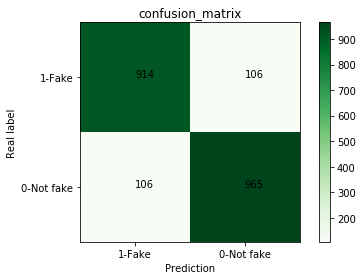

In [0]:
# Group1 Yichen Liu 2019.8

# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

We can see from above that our current model has reached :


1.   precision = 0.901
2.   recall = 0.901
3.   f1-score= 0.901

which is almost satisfactory.

In order to get  better performance, now we fix these three parameters and hypertune others.



In [0]:
# Group1 Yichen Liu 2019.8   
# Excecution Time = 3134.294 s

# Find best 'min_child_weight' & 'max_delta_step' under preset values

from sklearn.model_selection import GridSearchCV
parameters = {
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2]
}
    
xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=1,
			max_delta_step=0,
			subsample=0.85,
			colsample_bytree=0.7,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.875
Best parameters set:
	max_delta_step: 0.2
	min_child_weight: 0


In [0]:
# Group1 Yichen Liu 2019.8   
# Excecution Time =  1074.021 s

# Set  max_delta_step: 0.2 	min_child_weight: 0 according to above results

# Find best 'subsample' & 'colsample_bytree' under preset values

from sklearn.model_selection import GridSearchCV
parameters = {
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}
    
xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=0,
			max_delta_step=0.2,
			subsample=0.85,
			colsample_bytree=0.7,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.877
Best parameters set:
	colsample_bytree: 0.6
	subsample: 0.6


In [0]:
# Group1 Yichen Liu 2019.8   
# Excecution Time =  4955.827  s

# Set  max_delta_step = 0.2 	min_child_weight = 0   colsample_bytree = 0.6  subsample = 0.6 according to above results

# Find best 'reg_alpha' & 'reg_lambda' under preset values

from sklearn.model_selection import GridSearchCV
parameters = {
               'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
               'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1]
}
    
xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=0,
			max_delta_step=0.2,
			subsample=0.6,
			colsample_bytree=0.6,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=1,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.879
Best parameters set:
	reg_alpha: 0
	reg_lambda: 0.4


In [0]:
# Group1 Yichen Liu 2019.8   
# Excecution Time = 1108.327 s

# Set  max_delta_step = 0.2 	min_child_weight = 0   colsample_bytree = 0.6  subsample = 0.6 reg_alpha = 0 reg_lamda = 0.4 according to above results

# Find best 'scale_pos_weight' under preset values

from sklearn.model_selection import GridSearchCV
parameters = {
               'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
}
    
xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=0,
			max_delta_step=0.2,
			subsample=0.6,
			colsample_bytree=0.6,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=0.4,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.879
Best parameters set:
	scale_pos_weight: 1


Now we have the best set of hyperparameters, thus we can get the best performing xgb classifier

In [0]:
# Group1 Yichen Liu 2019.8   

# Final choice of XGboost Classifier 

xlf = xgb.XGBClassifier(max_depth=5,
			learning_rate=0.1,
			n_estimators=1000,
			silent=True,
			objective='binary:logistic',
			nthread=-1,
			gamma=0,
			min_child_weight=0,
			max_delta_step=0.2,
			subsample=0.6,
			colsample_bytree=0.6,
			colsample_bylevel=1,
			reg_alpha=0,
			reg_lambda=0.4,
			scale_pos_weight=1,
			seed=1440,
			missing=None)

xlf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0.2, max_depth=5,
              min_child_weight=0, missing=None, n_estimators=1000, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.4, scale_pos_weight=1, seed=1440,
              silent=True, subsample=0.6, verbosity=1)

In [0]:
from sklearn.metrics import classification_report
y_pred = xlf.predict(x_test)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [0]:
# Group1 Yichen Liu 2019.8

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

confusion matrix: 
[[917 103]
 [109 962]]
precision:   0.903
recall:   0.898
f1:   0.901


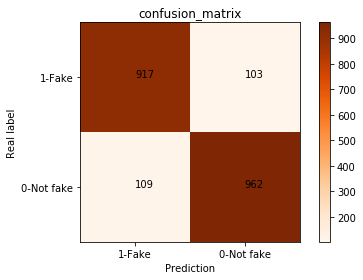

In [0]:
# Group1 Yichen Liu 2019.8

# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()



```
# This is formatted as code
```

So the final performance is :


1.   precision = 0.903
2.   recall = 0.898
3.   f1-score= 0.901


